### Summary

Football recruitment is about finding exceptional talents that fit into your team style.<br>
Often we try and find similar players to a player we like. But is there anyone like fan favourite Kevin De Bruyne?<br>
Here I instead find players that stand out, the outliers.<br>
These outliers may flag up a few exceptional talents for you to look at in your scouting process.

### Introducing outlier analysis

Most of the public football recruitment analysis tends to fall into three camps. Given a good player, could you find me a player with a similar style? Visualizations that show a fixed set of skills for a position, e.g. Radars. Scatter plots that show extreme values in one or two traits.

<br>I got interested in the last approach via a thread by [@MishraAbhiA]( https://twitter.com/MishraAbhiA). Yet, I am not satisfied with cherry-picking data and identifying a handful of players. Can we do better and scale this type of approach to look at many skills?<br>

<br>Outlier analysis is perfect for this. We use it in the industry to detect faulty machinery if we observe unusual sensor readings. Here we can take many skills and identify players where their mix of skills is unusual instead. We find these unique players via machine learning.

### What is an outlier?

An outlier is a player where their skills are far away from the other players. Robert Lewandowski scored 11 more goals than his nearest competitor Messi in 2020-21. He is a clear outlier in the big five leagues, according to [FBRef](https://fbref.com/en/).

> **"Recruitment is all about outliers. Find me the best players, in every trait, in every league, across the globe."** *Ted Knutson, StatsBomb Evolve, 17 March 2021.*

### Top outliers

In this blog, I identify outfield players who are outliers. I use their skill information, such as the number of interceptions per 90 minutes.

I exclude centre-backs as they are more challenging to scout with data. But [@EveryTeam_Mark](https://twitter.com/EveryTeam_Mark) wrote a great blog on [scouting centre-backs with statistics]( https://statsbomb.com/2017/07/how-do-you-scout-for-centre-backs-statistically/). 

As a sanity check, let's check out the top-10 players identified by their outlier score. The top players look pretty great to me.

In [1]:
#| include: false
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mplsoccer import FontManager
import matplotlib.patheffects as path_effects
from IPython.display import display_html, HTML

In [2]:
#| include: false
df = pd.read_parquet(os.path.join('data', 'outliers.parquet'))

In [3]:
#| echo: false
df_top_10 = df[['player_name_transfermarkt', 'squad_transfermarkt', 'position_transfermarkt']].head(10)
df_top_10.index = np.arange(1, 11)
df_top_10.index.name = 'Rank'
df_top_10.columns = ['Player', 'Team', 'Position']
df_top_10

Player             Team            Position
Rank                                                        
1                Neymar        Paris S-G         Left Winger
2        Marco Verratti        Paris S-G    Central Midfield
3          Lionel Messi        Barcelona        Right Winger
4        Ángel Di María        Paris S-G        Right Winger
5     Aleksey Miranchuk         Atalanta  Attacking Midfield
6          Josip Ilicic         Atalanta      Second Striker
7       Kevin De Bruyne  Manchester City  Attacking Midfield
8           David Silva    Real Sociedad  Attacking Midfield
9       Bruno Guimarães             Lyon    Central Midfield
10       Joshua Kimmich    Bayern Munich  Defensive Midfield

In [4]:
#| include: false
# create a text string with information about the player and their key stats (as defined by shap)

# rename the float versions of the position to a string version
# we didn't do this earlier as we couldn't store them as a parquet file with mixed columns (float/ string)
position_rename = {0: 'midfield', 1: 'wing back', 2: 'forward/winger'}
for i in range(1, 6):
    stat_name = f'stat_{i}_name'
    stat_value = f'stat_{i}_value'
    mask = df[stat_name] == 'position'
    df.loc[mask, stat_value] = df.loc[mask, stat_value].map(position_rename)

# version of the percentile columns, formated as a string with percentile after and with brackets, i.e. (100 percentile)
percentile_cols = [f'stat_{i}_percentile' for i in range(1, 52)]
df_percentile_str = df[percentile_cols].astype(str)
for col in percentile_cols:
    mask = df_percentile_str[col].str[-2:] == '.0'
    df_percentile_str.loc[mask, col] = ' (' + df_percentile_str.loc[mask, col].str[:-2] + ' percentile)'
    df_percentile_str.loc[~mask, col] = ''
    
# we use this to create a column with the player name, market value, age and the string version of the stats
df['text_str'] = ('<b>' + df['player_name_transfermarkt'] + '</b><br>' +
                  df['squad_transfermarkt'] + '<br>' +
                  'Age: ' + df['age_years_at_2021_07_01_transfermarkt'].astype(str) + '<br>' +
                  df['playing_time_min'].astype(int).astype(str) + ' mins played<br>' +
                  '€' + df['market_value_euros_millions_transfermarkt'].astype(str) +'m' + '<br><br>' +
                  '○ ' + df['stat_1_value'].astype(str) + ' <b>' + df['stat_1_name'] + '</b>' +
                  df_percentile_str['stat_1_percentile'] + '<br>' +
                  '○ ' + df['stat_2_value'].astype(str) + ' <b>' + df['stat_2_name'] + '</b>' +
                  df_percentile_str['stat_2_percentile'] + '<br>' +
                  '○ ' + df['stat_3_value'].astype(str) + ' <b>' + df['stat_3_name'] + '</b>' +
                  df_percentile_str['stat_3_percentile'] + '<br>' +
                  '○ ' + df['stat_4_value'].astype(str) + ' <b>' + df['stat_4_name'] + '</b>'+
                  df_percentile_str['stat_4_percentile'])

In [5]:
#| include: false
bins = [0, 10, 25, df.market_value_euros_millions_transfermarkt.max()]
df['transfermarkt_bins'] = pd.cut(df.market_value_euros_millions_transfermarkt, bins)
# smaller values has larger marker size for scatter plot
df['transfermarkt_bins_size'] = pd.cut(df.market_value_euros_millions_transfermarkt, bins,
                                       labels=[10, 8, 5])
df['transfermarkt_bins_size_matplotlib'] = pd.cut(df.market_value_euros_millions_transfermarkt, bins,
                                                  labels=[250, 125, 50])
df['transfermarkt_bins_colors'] = pd.cut(df.market_value_euros_millions_transfermarkt, bins,
                                       labels=['#7fe858', '#d5e44c', '#4fe4e4'])

In [6]:
#| include: false
# mapping
quantile_dict = {9: 'top 10%', 8: 'top 20%', 7: 'top 30%', 6: 'other', 5: 'other', 4: 'other',
                 3: 'other', 2: 'other', 1: 'other', 0: 'other'}
cols = ['outlier_score', 'age_years_at_2021_07_01_transfermarkt',
       'transfermarkt_bins_size', 'transfermarkt_bins_colors', 'text_str']

# back
df_back = df.loc[df.position_transfermarkt.isin(['Left-Back', 'Right-Back']), cols].copy()
df_back['quantile_num'] = pd.qcut(-df_back.outlier_score, 10, labels=False).map(quantile_dict)

# midfield
df_midfield = df.loc[df.position_transfermarkt.isin(['Attacking Midfield', 'Central Midfield',
                                                     'Defensive Midfield', 'Right Midfield',
                                                     'Left Midfield']), cols].copy()
df_midfield['quantile_num'] = pd.qcut(-df_midfield.outlier_score, 10, labels=False).map(quantile_dict)

# forward
df_forward = df.loc[df.position_transfermarkt.isin(['Left Winger', 'Right Winger',
                                                    'Second Striker', 'Centre-Forward']), cols].copy()
df_forward['quantile_num'] = pd.qcut(-df_forward.outlier_score, 10, labels=False).map(quantile_dict)

In [7]:
#| include: false
# add spare point to the the dataframe
# cheap hack to get the scatter legend to show dark grey points
spare_10 = {'outlier_score': 0, 'ageat_2021_05_01_transfermarkt': 0,
            'transfermarkt_bins_size': 5, 'transfermarkt_bins_colors': '#6e6e6e',
            'text_str': 'You found a spare marker', 'quantile_num': 'top 10%'}
spare_20 = spare_10.copy()
spare_20['quantile_num'] = 'top 20%'
spare_30 = spare_10.copy()
spare_30['quantile_num'] = 'top 30%'
spare_other = spare_10.copy()
spare_other['quantile_num'] = 'other'
df_spare = pd.DataFrame([spare_10, spare_20, spare_30, spare_other])

df_forward = pd.concat([df_spare, df_forward])
df_midfield = pd.concat([df_spare, df_midfield])
df_back = pd.concat([df_spare, df_back])

In [8]:
#| include: false
def scatter(df):
    fig = go.Figure(layout_yaxis_range=[0.37, 0.65],
                    layout_xaxis_range=[17, 40])

    line_color = '#5e8bff'
    annotate_font = dict(family='Impact', size=24, color='#7f7f7f')
    fillcolor = ['#e5e7f9', '#ccd1f9','#bac1fc', '#a1aafc', '#838ffc']
    for idx, age in enumerate([[17, 21], [21, 24], [24, 29], [29, 32], [32, 40]]):
        fig.add_vrect(x0=age[0], x1=age[1], opacity=0.15,
                      fillcolor=fillcolor[idx], line_width=0)
        if idx < 4:
            fig.add_vline(x=age[1], line_dash='dash', line_width=1, line_color=line_color)
    quantile_cuts = []
    quantile_text = ['top 10%', 'top 20%', 'top 30%']
    for quantile in [0.1, 0.2, 0.3]:
        cut = -df.outlier_score.quantile(quantile)
        quantile_cuts.append(cut)
        fig.add_hline(y=cut, line_dash='dash', line_width=1, line_color=line_color)

        
    for quantile in quantile_text:
        mask = df.quantile_num == quantile
        fig.add_trace(go.Scatter(x=df[mask].age_years_at_2021_07_01_transfermarkt,
                                 y=-df[mask].outlier_score,
                                 hovertemplate='%{text}<extra></extra>',
                                 mode='markers',
                                 text=df[mask]['text_str'],
                                 name=quantile,
                                 marker=dict(size=df[mask].transfermarkt_bins_size,
                                             color=df[mask].transfermarkt_bins_colors)))
    mask = df.quantile_num == 'other'
    fig.add_trace(go.Scatter(x=df[mask].age_years_at_2021_07_01_transfermarkt,
                             y=-df[mask].outlier_score,
                             hovertemplate='%{text}<extra></extra>',
                             mode='markers',
                             text=df[mask]['text_str'],
                             name='other',
                             marker=dict(size=df[mask].transfermarkt_bins_size,
                                         color=df[mask].transfermarkt_bins_colors)))
    fig.add_annotation(x=0.05, y=1.1, 
                       font=dict(size=14, color='#7fe858'),
                       xref='paper', yref='paper',
                       text='€0-10M', showarrow=False)
    fig.add_annotation(x=0.45, y=1.1, 
                       font=dict(size=14, color='#d5e44c'),
                       xref='paper', yref='paper',
                       text='€10-25M', showarrow=False)
    fig.add_annotation(x=0.85, y=1.1, 
                       font=dict(size=14, color='#4fe4e4'),
                       xref='paper', yref='paper',
                       text='€25M+', showarrow=False)
    
    fig.add_annotation(x=1.33, y=0.55,
                       #font=dict(size=12),
                       xref='paper', yref='paper',
                       text='Click legend<br>to add/remove<br>scatter points', showarrow=False)
    
    fig.add_annotation(x=-0.16, y=0.55, 
                       font=dict(size=12, color='black'),
                       xref='paper', yref='paper',
                       text='Outlier', showarrow=False)
    
    #quantile_cuts.append(quantile_cuts[-1] + 0.07)
    #quantile_text.append('outlier')
    
    fig.update_layout(autosize=False,
                      legend_title_text='<b>Outliers</b>',
                      width=400,
                      height=400,
                      xaxis_title="age",
                      #yaxis_title="outlier",
                      font=dict(family='Roboto', size=10),
                      plot_bgcolor='white',
                      margin=dict(l=10, r=10, b=10, t=60),
                      xaxis=dict(tickmode='linear', tick0=17, dtick=1),
                      yaxis=dict(tickmode='array', tickvals=quantile_cuts, ticktext=quantile_text),              
                      hoverlabel=dict(font_size=10, font_family="Roboto"))
    fig.update_xaxes(showgrid=False, autorange=False, tickfont=dict(family='Roboto', size=10))
    fig.update_yaxes(showgrid=False, autorange=False, tickfont=dict(family='Roboto', size=10))
    fig.show(config={'modeBarButtonsToRemove':['autoScale2d', 'toggleSpikelines', 'hoverCompareCartesian']})
    return fig

### The data

I include players who played in the big-5 leagues in England, France, Germany, Spain and Italy in 2020-21. I then exclude players who played fewer than 675 minutes over the last three seasons.

The data comes from [FBRef](hhttps://fbref.com/en/) via StatsBomb and [Transfermarkt](https://www.transfermarkt.com/).

I combine player data over the last three seasons, so each player has one line. Combining the data ensures that the youngest players have enough data to analyze.

### Find your favourite player
The best way to show the potential of this outlier analysis is to show some interactive plots. Higher points in the chart are outliers. Younger players are towards the left of the charts. For each player, I highlight the top 4 statistics that contribute the most to their outlier score.

I have split the charts into three positions. You can toggle points away by clicking on the legend, e.g. to see only the top 10% of players. On mobile, you double click the chart to zoom out.

Can you find any gems?

### Left/ Right Backs

In [9]:
#| echo: false
fig = scatter(df_back)

### Midfielders

In [10]:
#| echo: false
fig = scatter(df_midfield)

### Forwards

In [11]:
#| echo: false
fig = scatter(df_forward)

> Chart age profiles inspired by [@utdarena](https://twitter.com/utdarena).

In [12]:
#| include: false
df = pd.read_parquet(os.path.join('data', 'outliers.parquet'))

In [13]:
#| include: false
player_name = 'Rayan Cherki'

In [14]:
#| include: false
player_position = df.loc[df.player_name_transfermarkt == player_name, 'position'].iloc[0]
player_cost = df.loc[df.player_name_transfermarkt == player_name, 'market_value_euros_millions_transfermarkt'].iloc[0]
player_mins = df.loc[df.player_name_transfermarkt == player_name, 'playing_time_min'].iloc[0]
player_age = df.loc[df.player_name_transfermarkt == player_name, 'age_years_at_2021_07_01_transfermarkt'].iloc[0]
player_outlier = - df.loc[df.player_name_transfermarkt == player_name, 'outlier_score'].iloc[0]

In [15]:
#| include: false
player_skill_names = df.loc[df.player_name_transfermarkt == player_name, [f'stat_{i}_name' for i in range(1, 52)]]
player_skill_names = np.squeeze(player_skill_names.values)
mask = player_skill_names != 'position'
player_skill_names = player_skill_names[mask].copy()

In [16]:
#| include: false
player_skill_values = df.loc[df.player_name_transfermarkt == player_name, [f'stat_{i}_value' for i in range(1, 52)]]
player_skill_values = np.squeeze(player_skill_values.values)
player_skill_values = player_skill_values[mask].copy()

In [17]:
#| include: false
player_skill_percentiles = df.loc[df.player_name_transfermarkt == player_name, [f'stat_{i}_percentile' for i in range(1, 52)]]
player_skill_percentiles = np.squeeze(player_skill_percentiles.values)
player_skill_percentiles = player_skill_percentiles[mask].copy()

In [18]:
#| include: false
categorise = {# offensive
              'xG (non-penalty)': 'offensive 1',
              'xG per shot (non-penalty)': 'offensive 1',
              'goals per shot': 'offensive 1', 
              'shot distance (average)': 'offensive 1',
              '% of shots on target': 'offensive 1',
              'xG assisted': 'offensive 2',
              'dead-ball pass leading to a shot attempt': 'offensive 2',
              'dribbles leading to a shot attempt': 'offensive 2',
              'shots leading to another shot attempt': 'offensive 2',
              'fouls drawn leading to a shot attempt': 'offensive 2',
              'defensive actions leading to a shot attempt': 'offensive 2',
              'fouls drawn': 'offensive 3',
              'touches (# att 3rd)': 'offensive 3',
              'nutmegs': 'offensive 3',
              # passing / passing recieved / carries
              'progressive passing distance': 'carries - passing 1',
              'passes into final third': 'carries - passing 1',
              'passes into penalty area': 'carries - passing 1',
              'crosses into penalty area': 'carries - passing 1',
              'progressive passes received (#)': 'carries - passing 1',
              'through balls': 'carries - passing 1',
              'switches': 'carries - passing 2',
              'high passes (#)': 'carries - passing 2',
              'left foot pass attempts (#)': 'carries - passing 2',
              '% of long passes completed': 'carries - passing 2',
              'target of attempted pass (#)': 'carries - passing 2',
              'short passes completed (#)': 'carries - passing 2',
              'carries (#)': 'carries - passing 3',
              'carries progressive distance': 'carries - passing 3',
              'carries into penalty area': 'carries - passing 3',
              '% of dribbles successful': 'carries - passing 3',
              # defensive
              'tackles won': 'defensive 1',
              'tackles (def 3rd)': 'defensive 1',
              'tackles (att 3rd)': 'defensive 1', 
              'dribblers tackled': 'defensive 1',
              '% of dribblers tackled': 'defensive 1',
              'successful pressures': 'defensive 2',
              '% of pressures successful': 'defensive 2',
              'pressures (def 3rd)': 'defensive 2',
              'pressures (mid 3rd)': 'defensive 2',
              'pressures (att 3rd)': 'defensive 2',
              'blocks': 'defensive 3',
              'shots blocked': 'defensive 3',
              'shots blocked (on-target)': 'defensive 3',
              'interceptions': 'defensive 3',
              'clearances': 'defensive 4',
              'ball recoveries': 'defensive 4',
              'aerial duels won': 'defensive 4',
              '% of aerials won': 'defensive 4',
              # team
              'xG allowed by team while on pitch': 'team',
              'xG scored minus allowed by team while on pitch': 'team',}

In [19]:
#| include: false
player_skill_cats = pd.Series(player_skill_names).map(categorise).values

In [20]:
#| include: false
cat_order = ['offensive 1', 'offensive 2', 'offensive 3', 'carries - passing 1',
             'carries - passing 2', 'carries - passing 3', 'defensive 1', 'defensive 2', 'defensive 3', 'team']
cat_order = np.array(cat_order)[::-1]

In [21]:
#| include: false
bar_names = []
bar_percentiles = []
bar_values = []
for cat in cat_order:
    cat_percentiles = player_skill_percentiles[player_skill_cats == cat].copy()
    cat_names = player_skill_names[player_skill_cats == cat].copy()
    cat_values = player_skill_values[player_skill_cats == cat].copy()
    cat_idx_sort = cat_percentiles.argsort().copy()
    
    bar_names.append(cat_names[cat_idx_sort])
    bar_percentiles.append(cat_percentiles[cat_idx_sort])
    bar_values.append(cat_values[cat_idx_sort])
    bar_names.append([''])
    bar_percentiles.append([0])
    bar_values.append([''])
bar_percentiles = np.concatenate(bar_percentiles)[:-1]
bar_names = np.concatenate(bar_names)[:-1]
bar_values = np.concatenate(bar_values)[:-1]

In [22]:
#| include: false
colors = ['#d8a499'] * 3 + ['#7294d4'] * 16 + ['#e688b8'] * 19 + ['#c6cdf7'] * 17

In [23]:
#| include: false
bar_names1 = bar_names[:-36].copy()
bar_percentiles1 = bar_percentiles[:-36].copy()
bar_values1 = bar_values[:-36].copy()
colors1 = np.array(colors[:-36]).copy()
colors1[bar_percentiles1 <= 50] = '#b8bcbb'

bar_names2 = bar_names[-35:].copy()
bar_percentiles2 = bar_percentiles[-35:].copy()
bar_values2 = bar_values[-35:].copy()
colors2 = np.array(colors[-35:]).copy()
colors2[bar_percentiles2 <= 50] = '#b8bcbb'

In [25]:
#| include: false
fm = FontManager()
fm_oxygen = FontManager('https://github.com/google/fonts/blob/main/ofl/oxygen/Oxygen-Bold.ttf?raw=True')
fm_roboto_italic = FontManager('https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Italic.ttf?raw=True')

In [26]:
#| include: false
quantile_cuts = []
for q in [0.7, 0.8, 0.9]:
    cut = (-df.loc[df.position == player_position, 'outlier_score']).quantile(q)
    quantile_cuts.append(cut)

### Who stands out for you?

> **"[Analysis] pays off in avoiding mistakes and finding better players for your budget."** *Ted Knutson, StatsBomb Evolve, 17 March 2021*

When I was playing around with the interactive charts, I liked the look of Rayan Cherki. Let's zoom into his profile and see each of the 50 statistics that go into the outlier analysis. He is a decent attacking midfielder who presses in the final third.

If your want to profile another player, then ping a message to [@numberstorm](https://twitter.com/numberstorm) on Twitter.

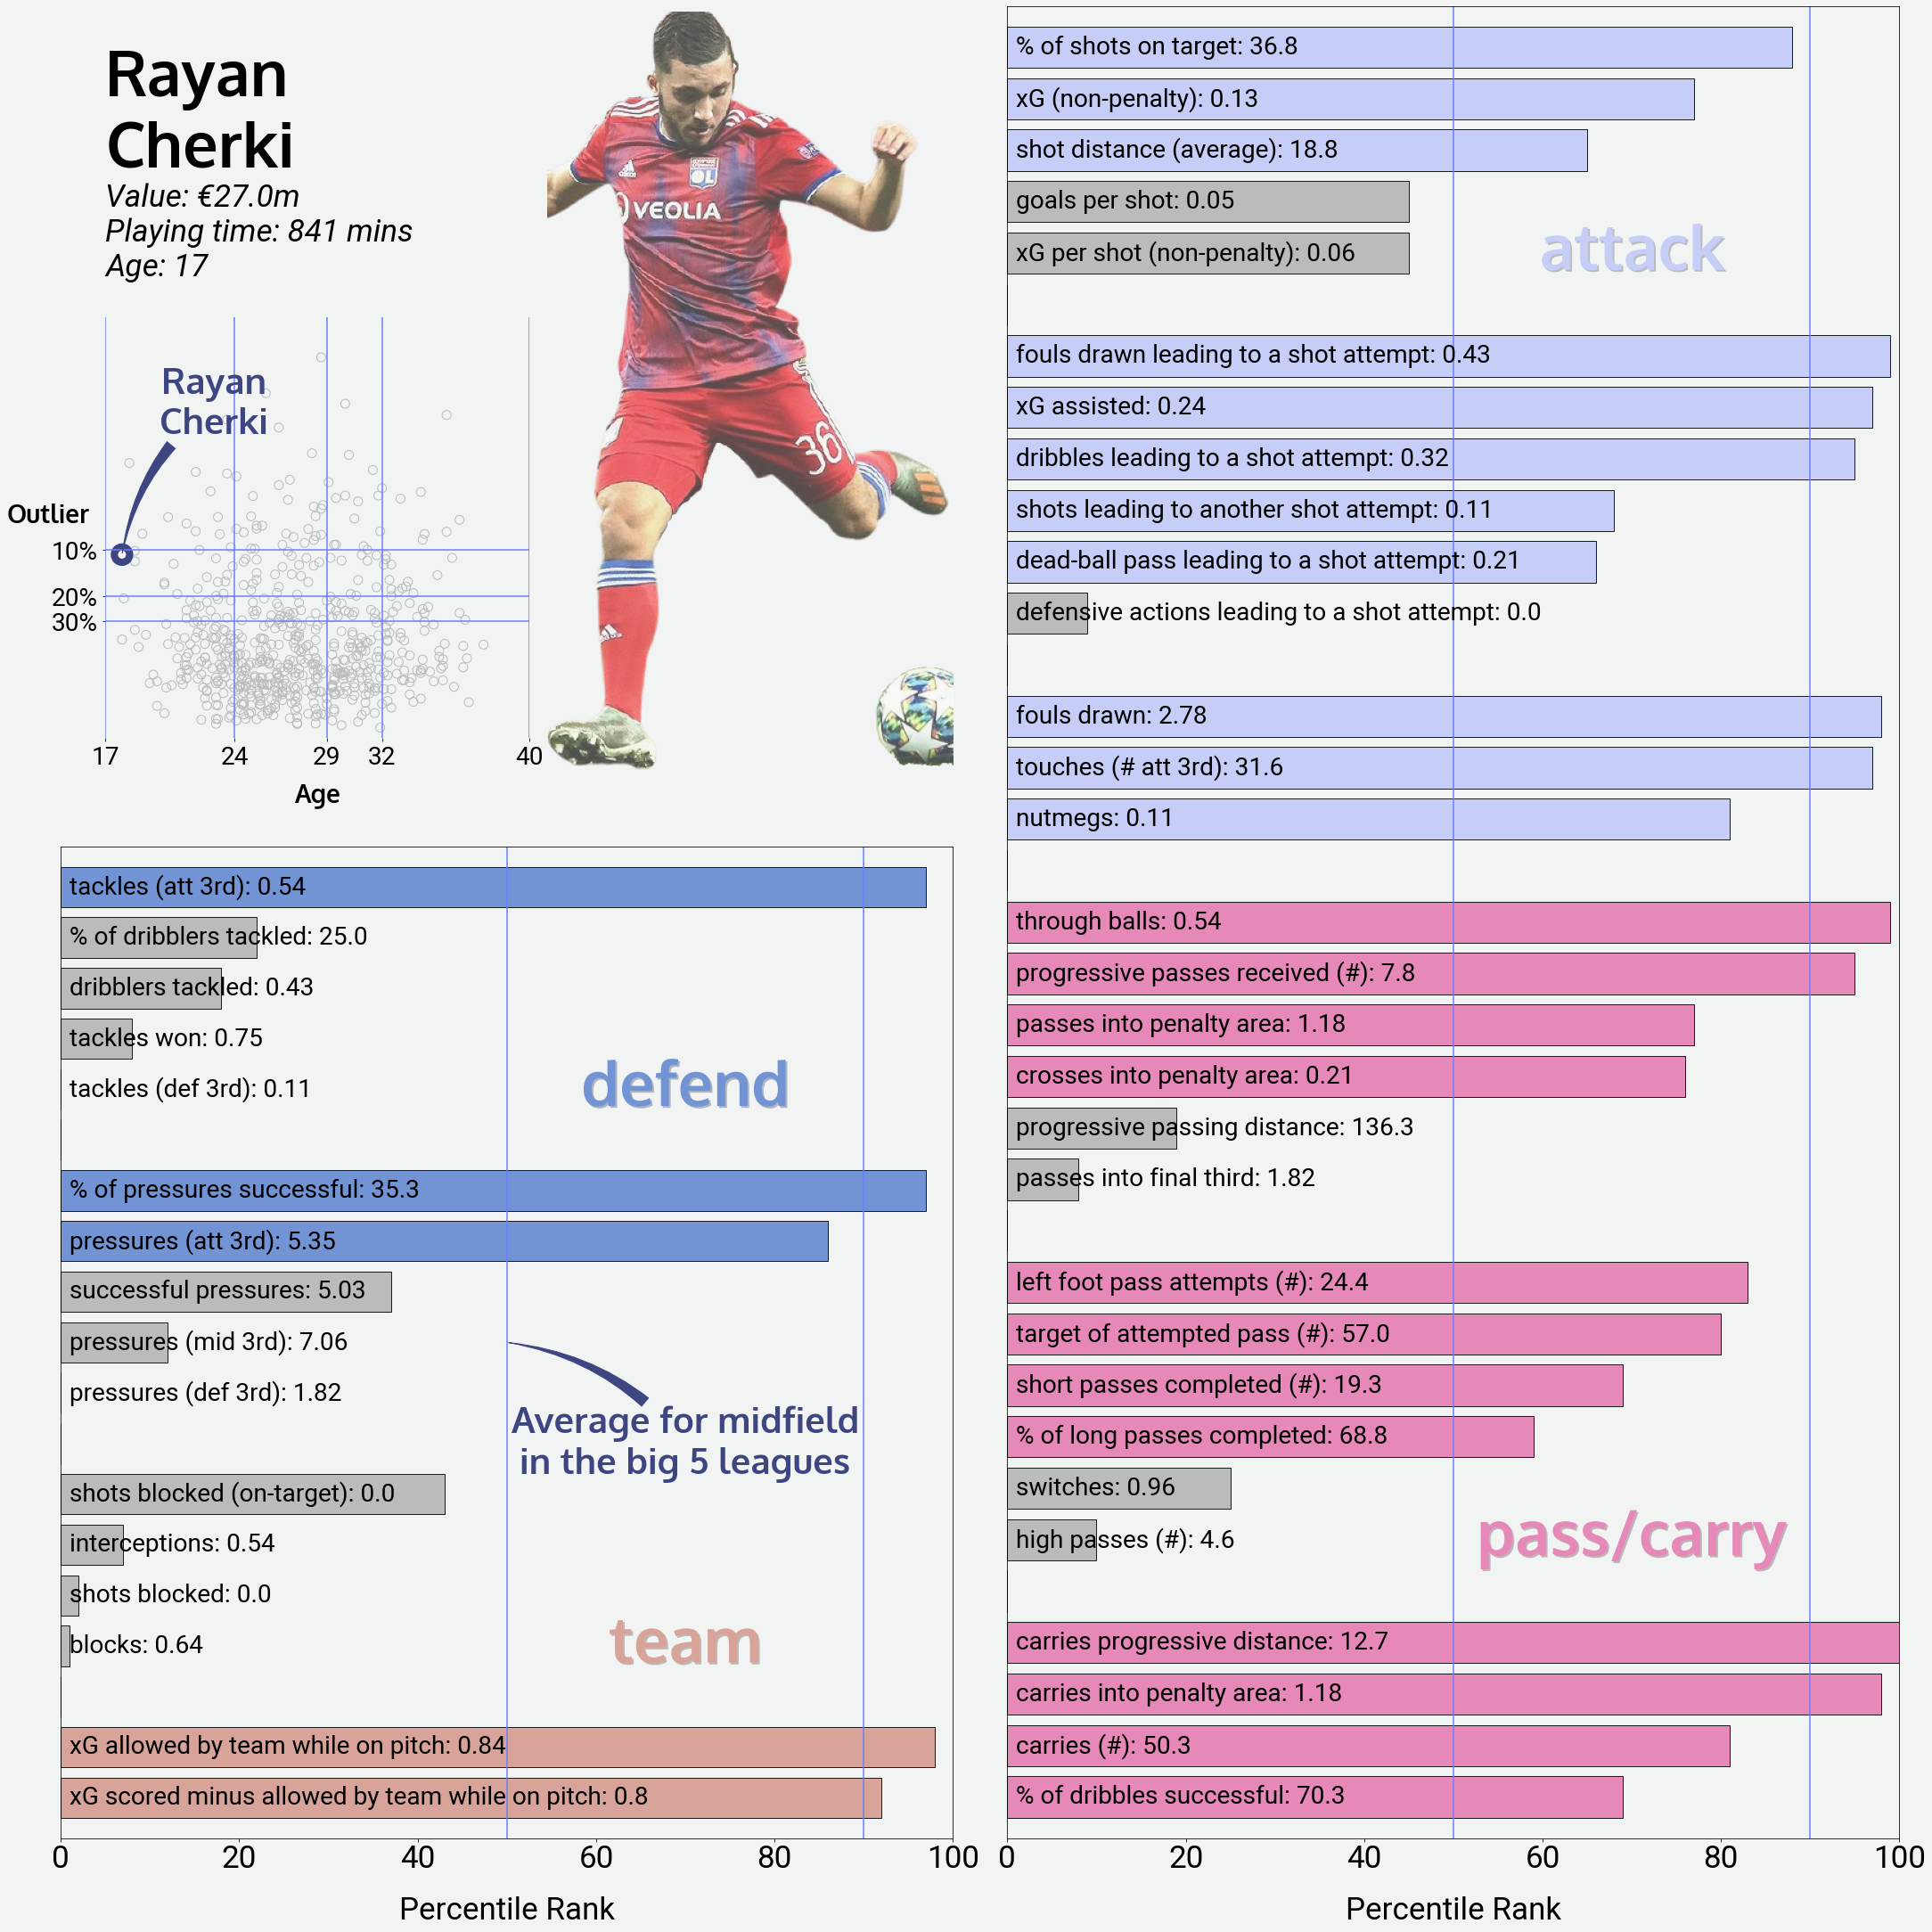

In [27]:
#| echo: false
# create grid
layout = """
         AC
         BC
         """
height1 = (len(bar_names1) / len(bar_names2)) + 0.02
height2 = 1 - height1
fig = plt.figure(constrained_layout=True, figsize=(30, 30))
axs = fig.subplot_mosaic(layout,
                         gridspec_kw={'height_ratios': [height2, height1]})

# split top left box into three inset-axes: top-left text, bottom-left scatter, right image
image = plt.imread('Rayan_Cherki.png')
image_height, image_width, _ = image.shape
fig_pixels = (fig.get_size_inches() * fig.dpi)
pixel_width = fig_pixels[0] * axs['A'].get_position().width
pixel_height = fig_pixels[1] * axs['A'].get_position().height
inset_axes_width = (pixel_height / image_height * image_width) / pixel_width
ax_image = axs['A'].inset_axes([1 - inset_axes_width, 0, inset_axes_width, 1])
ax_scatter = axs['A'].inset_axes([0.05, 0.05, 1 - inset_axes_width - 0.07, 1 - inset_axes_width])
ax_text = axs['A'].inset_axes([0.05, 0.1 + 1 - inset_axes_width,
                               1 - inset_axes_width - 0.07, 1 - 0.05 - (0.1 + 1 - inset_axes_width)])

# turn-off the axes or make the spine invisible for top left cell of the grid
axs['A'].axis('off')
ax_text.axis('off')
ax_image.axis('off')
for spine in ['top', 'left', 'right', 'bottom']:
    ax_scatter.spines[spine].set_visible(False)
    
# set fig/ axes facecolors
ax_scatter.set_facecolor('#f2f4f3')
fig.set_facecolor('#f2f4f3')
for key in axs.keys():
    axs[key].set_facecolor('#f2f4f3')

# text box (top-left cell)
ax_text.text(0, 0.7, '\n'.join(player_name.split(' ')), fontproperties=fm_oxygen.prop, fontsize=70,
             va='center', ha='left')
ax_text.text(0, 0.2, f'Value: €{player_cost}m\nPlaying time: {int(player_mins)} mins\nAge: {int(player_age)}',
             fontproperties=fm_roboto_italic.prop, fontsize=35,
             va='center', ha='left')

# scatter (top-left cell)
ax_scatter.set_xlim(17, 40)
ax_scatter.set_xticks([17, 24, 29, 32, 40])
ax_scatter.set_xlabel('Age', fontproperties=fm_oxygen.prop, fontsize=28, labelpad=15)
for tick in ax_scatter.xaxis.get_major_ticks():
    tick.label.set_font_properties(fm.prop)
    tick.label.set_fontsize(28)
    tick.set_pad(5)
for age_loc in [17, 24, 29, 32, 40]:
    ax_scatter.axvline(age_loc, 0, 1, color='#6c7dfc')

ax_scatter.set_ylim(0.37, 0.65)
ax_scatter.set_yticks(quantile_cuts)
ax_scatter.set_yticklabels(['30%', '20%', '10%'])

ax_scatter.set_ylabel('Outlier', fontproperties=fm_oxygen.prop, fontsize=28, rotation=0)
for tick in ax_scatter.yaxis.get_major_ticks():
    tick.label.set_font_properties(fm.prop)
    tick.label.set_fontsize(28)
    tick.set_pad(5)
for cut_loc in quantile_cuts:
    ax_scatter.axhline(cut_loc, 0, 1, color='#6c7dfc')

x = df[df.position == player_position].age_years_at_2021_07_01_transfermarkt
y = - df[df.position == player_position].outlier_score
ax_scatter.scatter(x, y, s=100, facecolor='None', edgecolor='#b8bcbb')

ax_scatter.scatter(player_age, player_outlier, s=300, facecolor='None', edgecolor='#3e4682', linewidth=8)
ax_scatter.annotate('\n'.join(player_name.split(' ')),
                    xy=(player_age, player_outlier), xytext=(player_age + 5, player_outlier + 0.1),
                    fontproperties=fm_oxygen.prop, fontsize=40, va='center', ha='center', color='#3e4682',
                    arrowprops=dict(arrowstyle='wedge', connectionstyle='arc3,rad=0.2', color='#3e4682'))

# image (top-left cell)
ax_image.imshow(image, alpha=0.7)
#ax_image.text(350, 550,
#              'Image by Кирилл Венедиктов\nhttps://en.wikipedia.org/wiki/\nRayan_Cherki#/media/File:Rayan_Cherki_2019.jpg',
#              va='center', ha='right', fontsize=12,
#             )

# bar chart (bottom-left cell)
y_pos1 = np.arange(len(bar_names1))

axs['B'].set_yticks([]) 
axs['B'].set_xlim(0, 100)
axs['B'].set_xlabel('Percentile Rank', fontproperties=fm.prop, fontsize=35, labelpad=25)
for tick in axs['B'].xaxis.get_major_ticks():
    tick.label.set_font_properties(fm.prop)
    tick.label.set_fontsize(35)
axs['B'].set_ylim(min(y_pos1) - 0.8, max(y_pos1) + 0.8)
axs['B'].axvline(50, 0, 1, color='#6c7dfc')
axs['B'].axvline(90, 0, 1, color='#6c7dfc')

axs['B'].barh(y_pos1, bar_percentiles1, align='center', height=0.8,
              color=colors1, edgecolor='#1c1c1c')
for idx, label in enumerate(bar_names1):
    if label != '':
        label = f'{label}: {bar_values1[idx]}'
    axs['B'].text(1, y_pos1[idx], label, fontsize=28, fontproperties=fm.prop, va='center', ha='left')

axs['B'].annotate(f'Average for {player_position}\nin the big 5 leagues', xy=(50, y_pos1[9]), xytext=(70, y_pos1[7]),
                  fontproperties=fm_oxygen.prop, fontsize=40, va='center', ha='center', color='#3e4682',
                  arrowprops=dict(arrowstyle='wedge', connectionstyle='arc3,rad=0.2', color='#3e4682'))
axs['B'].text(70, y_pos1[14], 'defend', fontproperties=fm_oxygen.prop, color='#7294d4',
              va='center', ha='center', fontsize=70, path_effects=[path_effects.withSimplePatchShadow()])
axs['B'].text(70, y_pos1[3], 'team', fontproperties=fm_oxygen.prop, color='#d8a499',
              va='center', ha='center', fontsize=70, path_effects=[path_effects.withSimplePatchShadow()])

# bar chart (right cell)
y_pos2 = np.arange(len(bar_names2))

axs['C'].set_yticks([]) 
axs['C'].set_xlim(0, 100)
axs['C'].set_xlabel('Percentile Rank', fontproperties=fm.prop, fontsize=35, labelpad=25)
for tick in axs['C'].xaxis.get_major_ticks():
    tick.label.set_font_properties(fm.prop)
    tick.label.set_fontsize(35)
axs['C'].set_ylim(min(y_pos2) - 0.8, max(y_pos2) + 0.8)
axs['C'].axvline(50, 0, 1, color='#6c7dfc')
axs['C'].axvline(90, 0, 1, color='#6c7dfc')

axs['C'].barh(y_pos2, bar_percentiles2, height=0.8,
              align='center', color=colors2, edgecolor='#1c1c1c')
for idx, label in enumerate(bar_names2):
    if label != '':
        label = f'{label}: {bar_values2[idx]}'
    axs['C'].text(1, y_pos2[idx], label, fontsize=28, fontproperties=fm.prop, va='center', ha='left')

axs['C'].text(70, y_pos2[30], 'attack', fontproperties=fm_oxygen.prop, color='#c6cdf7',
              va='center', ha='center', fontsize=70, path_effects=[path_effects.withSimplePatchShadow()])
axs['C'].text(70, y_pos2[5], 'pass/carry', fontproperties=fm_oxygen.prop, color='#e688b8',
              va='center', ha='center', fontsize=70, path_effects=[path_effects.withSimplePatchShadow()]);

#fig.savefig('rayan_cherki_template.png')

> Chart inspired by [@HenshawAnalysis](https://twitter.com/HenshawAnalysis).
> [Image](https://commons.wikimedia.org/wiki/File:Rayan_Cherki_2019.jpg) credit: Кирилл Венедиктов


### What is the outlier score?

If you got this far, you might want to know more details about the method for deciding outliers. All the code for this blog is open-source in my [Github repo](https://github.com/andrewRowlinson/outliers-football). The recipe for detecting outliers is:

1. Download data from FBRef of the big-5 leagues for the last three seasons (2018-19, 2019-20 & 2020-21).
2. Combine the player data so that there is one line per player. Create totals for each statistic over the last three years. Recalculate statistics such as percentages, ratios, and averages from the raw data.
3. Download Transfermarkt data and fuzzy match to the FBRef data.
4. Exclude players who played zero minutes for a team during 2020-21 in the big-5 leagues.
5. Exclude players who played fewer than 675 minutes (approx 7.5 games) over the last three seasons.
6. Exclude players who play at centre-back or goalkeeper. You might want to run your own analysis on these positions.
7. Drop some columns that we do not want to use for outlier detection, such as yellow cards or penalties. My choice here is the number of cards does not matter. I also do not want to identify a player for taking rare set pieces.
8. Remove correlated features. I want to make it harder to identify players who rate high in several correlated skills. For example, Jack Grealish excels in many skills related to dribbles and carries. As I keep fewer of these skills in the data, it is harder to identify him as an outlier via dribbles only.
9. Add a column for the player's position. You might instead want to make different models for each player position. I let the model decide whether the player position was an important feature.
10. Change the bottom 40-50% for each statistic so that all the players near the bottom have the same value. I don't want to flag people as outliers for their poor figures.
11. Use the isolation forests algorithm from sci-kit to identify outliers. Use SHAP values to identify the top contributors to the outlier score.


:::{.callout-note}

[Isolation forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) scores each football player for their uniqueness. It builds several trees which randomly split the players by a random statistic, such as expected goals. The fewer splits required to isolate a player, the more likely the player is an outlier.

:::
<br>



### Discussion

A large majority of a player's time in football is off the ball. But most of the stats in this analysis ignore this. The stats also ignore the context in which the team plays.

<br>There is also an interesting blog by [TiotalFootball](https://twitter.com/TiotalFootball) about how tracking data might provide greater context. With some clever engineering, you could create some off-ball events from tracking data and StatsBomb's new 360 data, which could complement this analysis.

<br>If you want to extend this analysis, here are a few ideas:

- include central defenders
- adjust the stats for possession or the league to account for stylistic differences
- identify players with unique passing styles. You could bin or cluster passes to create totals and use these to identify outliers
- add off-the-ball features or speed data
- create separate models for each position

### Get in touch

I would love to hear your thoughts or feedback. Please get in touch on Twitter [@numberstorm](https://twitter.com/numberstorm) or via email at rowlinsonandy@gmail.com.